In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
RANDOM_SEED = 28101990

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'

# Load data

In [3]:
df = pd.read_csv(f'{processed_data_dir}data.csv').drop('Unnamed: 0', axis=1)

Drop data that has nans

In [4]:
df = df.dropna()

In [5]:
df

,xp (A),yp (A),tp (ns),thickness (A),mean curvature,apl,lipid order,membrane
0,63,119,1.4,31.726623,0.005068,74.286328,0.117472,por1
1,196,296,2.8,31.007392,-0.022442,90.877349,0.211274,por1
2,164,96,5.2,27.029021,-0.069034,70.429585,0.196442,por1
3,253,130,3.4,26.889139,0.037281,73.119575,0.187620,por1
4,228,163,4.2,29.676475,-0.020645,60.521201,0.103665,por1
...,...,...,...,...,...,...,...,...
235,12,51,5.7,30.283941,0.007363,102.785558,0.197651,por4
236,182,283,7.1,31.555795,0.036120,66.171669,0.178266,por4
237,53,62,6.6,29.632661,0.001431,94.653788,0.145256,por4
238,81,278,2.8,31.855390,0.009983,94.840233,0.093207,por4


## Visualize Data

array([[<AxesSubplot:title={'center':'por1'}>,
        <AxesSubplot:title={'center':'por2'}>],
       [<AxesSubplot:title={'center':'por3'}>,
        <AxesSubplot:title={'center':'por4'}>]], dtype=object)

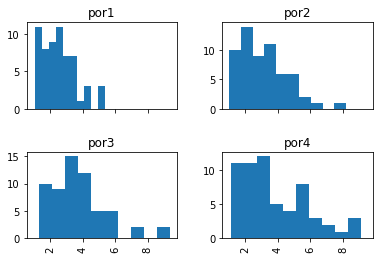

In [6]:
df['tp (ns)'].hist(by=df['membrane'],sharex=True)

# Non-Hierarchical Model

In [147]:
from pymc3 import DensityDist
from pymc3.math import switch,exp

In [148]:
import theano.tensor as T

In [149]:
def logp_exp_lag(tau_0, tau):
    def logp_(t):
        return T.log(T.switch(T.lt(t, tau_0), np.finfo(np.float64).tiny,T.exp( - (t - tau_0) / tau)/ tau ))
    return  logp_

In [150]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self,t, tau_0, tau):
        if t < tau_0:
            pdf = np.finfo(np.float64).tiny
        else:
            pdf = np.exp( - (t - tau_0) / tau)/ tau 
        return pdf  
my_cv = my_pdf( name='my_pdf')

In [161]:
from pymc3.distributions import draw_values, generate_samples
def random(tau_0, tau, point=None, size=None):
    # draw a numerical value for the parameters
    size = 1 if size is None else size
    tau_0_, tau_ = draw_values([tau_0, tau], point=point,size=size)
    
 
    return generate_samples(my_cv.rvs, tau=tau_, tau_0=tau_0_, size=size)

In [162]:
d = DensityDist.dist(logp_exp_lag).logp(3,0.5)

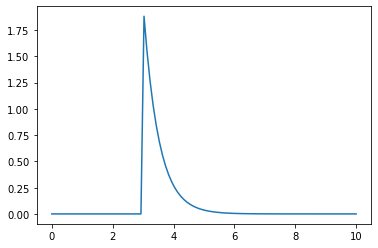

In [163]:
plt.plot(np.linspace(0,10,100),np.exp(d(np.linspace(0,10,100)).eval()))

In [164]:
with pm.Model() as my_model:
    data = df['tp (ns)']
    tau = pm.Uniform('tau', 0., 6, )
    tau_0 = pm.Uniform('tau_0', 0., 30)
    like = DensityDist('like', logp_exp_lag(tau_0,tau), observed=data, random=random(tau_0, tau))                    

In [165]:
with my_model:
    my_model_trace = pm.sample(1000,  random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(my_model_trace,  random_seed=RANDOM_SEED, samples=250, size=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_0, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 454 divergences after tuning. Increase `target_accept` or reparameterize.
There were 356 divergences after tuning. Increase `target_accept` or reparameterize.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
%%time
l = []
for i in range(100):
    l.append(my_cv.rvs(tau_0=3, tau=0.5))

(array([42., 24., 10., 10.,  9.,  3.,  1.,  0.,  0.,  1.]),
 array([3.00586809, 3.23522099, 3.46457389, 3.69392679, 3.92327969,
        4.15263259, 4.3819855 , 4.6113384 , 4.8406913 , 5.0700442 ,
        5.2993971 ]),
 <BarContainer object of 10 artists>)

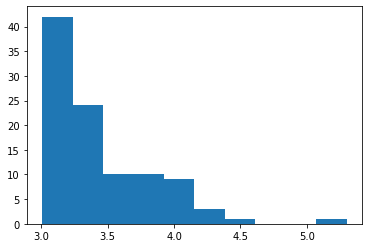

In [39]:
plt.hist(np.array(l))

In [ ]:
my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)